In [1]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install rouge-score

In [7]:
# Cell 1: imports & config
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pprint import pprint

# TensorFlow
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# project helpers (assumes files are in working dir)
from src.utils import set_seed, make_synthetic_examples, build_tf_datasets_from_examples, examples_to_numpy, preprocess_image_pil
import src.train as train_mod
from src.model import build_model

# load config
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

pprint(config)
set_seed(42)


TensorFlow version: 2.20.0
{'dataset': {'batch_size': 16,
             'hf_name': 'daniel3303/StoryReasoning',
             'image_size': 128,
             'max_caption_len': 32,
             'max_reason_len': 32,
             'seq_len': 3},
 'model': {'bos_token_id': 101,
           'eos_token_id': 102,
           'image_feat_dim': 512,
           'multimodal_dim': 512,
           'pad_token_id': 0,
           'reason_embed_dim': 256,
           'reason_hidden_dim': 512,
           'temporal_hidden_dim': 512,
           'text_decoder_hidden': 512,
           'text_embed_dim': 300,
           'text_hidden_dim': 512,
           'vocab_size': 30522},
 'training': {'device': 'auto',
              'epochs': 5,
              'grad_clip': 1.0,
              'log_interval': 50,
              'lr': '1e-4',
              'save_dir': 'results/checkpoints'}}


In [6]:
# Cell 2: Load FULL dataset from HuggingFace and convert to `examples` list
# Produces: examples = [{'images':[PIL.Image,...], 'caption_tokens':[int,...]}, ...] for the whole dataset

from datasets import load_dataset
from transformers import BertTokenizerFast
from PIL import Image
from tqdm.auto import tqdm

hf_name = config['dataset'].get('hf_name', 'daniel3303/StoryReasoning')
seq_len = config['dataset']['seq_len']
bos_id = config['model'].get('bos_token_id', 101)
eos_id = config['model'].get('eos_token_id', 102)

print("Loading HF dataset:", hf_name)
ds_all = load_dataset(hf_name)  # may return a dict of splits

# concatenate splits (if multiple) into a single iterable
if isinstance(ds_all, dict):
    datasets_iter = []
    for split_name, split_ds in ds_all.items():
        print(" - found split:", split_name, "with", len(split_ds), "examples")
        datasets_iter.append(split_ds)
    # create a concatenated dataset object for iteration
    from datasets import concatenate_datasets
    dataset = concatenate_datasets(datasets_iter)
else:
    dataset = ds_all

print("Total examples in HF dataset:", len(dataset))

# Build tokenizer (BERT)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', use_fast=True)

examples = []

# Helper to extract images from a dataset record
def extract_frame_list(record):
    # Try common keys
    for key in ('images', 'frames', 'frame_paths', 'image_list'):
        if key in record and record[key] is not None:
            val = record[key]
            # If it's a list of image objects/paths
            if isinstance(val, list):
                frames = []
                for v in val:
                    # If v is already PIL.Image (datasets Image feature returns PIL.Image)
                    if hasattr(v, 'convert'):
                        frames.append(v.convert('RGB'))
                    else:
                        # if it's a dict with 'path' or 'bytes'
                        if isinstance(v, dict) and 'path' in v:
                            frames.append(Image.open(v['path']).convert('RGB'))
                        else:
                            # last resort: try open as path
                            frames.append(Image.open(v).convert('RGB'))
                return frames
            else:
                # single image -> wrap into list
                v = val
                if hasattr(v, 'convert'):
                    return [v.convert('RGB')]
                elif isinstance(v, dict) and 'path' in v:
                    return [Image.open(v['path']).convert('RGB')]
                else:
                    return [Image.open(v).convert('RGB')]
    # fallback: check for single 'image' key
    if 'image' in record and record['image'] is not None:
        v = record['image']
        if isinstance(v, list):
            return [x.convert('RGB') if hasattr(x, 'convert') else Image.open(x).convert('RGB') for x in v]
        else:
            return [v.convert('RGB') if hasattr(v, 'convert') else Image.open(v).convert('RGB')]
    # If nothing found, return None
    return None

# Helper to get caption tokens (use existing tokens if present, else tokenize caption text)
def get_caption_tokens(record):
    # Prefer explicit token field
    for key in ('caption_tokens', 'tokens', 'token_ids'):
        if key in record and record[key] is not None:
            # ensure ints
            return [int(x) for x in record[key]]
    # Else look for text caption
    for key in ('caption', 'caption_text', 'text', 'story'):
        if key in record and record[key] is not None:
            txt = record[key]
            if isinstance(txt, list):
                # join list into string if necessary
                txt = ' '.join(txt)
            # tokenize (without adding special tokens) then add bos/eos from config
            token_ids = tokenizer.encode(txt, add_special_tokens=False)
            if bos_id is not None:
                token_ids = [bos_id] + token_ids
            if eos_id is not None:
                token_ids = token_ids + [eos_id]
            return token_ids
    # If no caption found, return empty caption with BOS/EOS
    return [bos_id, eos_id] if bos_id is not None and eos_id is not None else []

# Iterate entire dataset and build examples
print("Converting HF dataset into examples list (this may take a while for large datasets)...")
for rec in tqdm(dataset):
    frames = extract_frame_list(rec)
    if frames is None:
        # skip records with no frames
        continue
    # enforce seq_len: if fewer frames, repeat last; if more, take first seq_len
    if len(frames) < seq_len:
        frames = frames + [frames[-1]] * (seq_len - len(frames))
    else:
        frames = frames[:seq_len]

    caption_tokens = get_caption_tokens(rec)
    examples.append({'images': frames, 'caption_tokens': caption_tokens})

print("Built examples list with total items:", len(examples))
# Quick sanity print
print("Example keys:", list(examples[0].keys()))
print("First example caption tokens (first 20):", examples[0]['caption_tokens'][:20])


Loading HF dataset: daniel3303/StoryReasoning
 - found split: train with 3552 examples
 - found split: test with 626 examples
Total examples in HF dataset: 4178
Converting HF dataset into examples list (this may take a while for large datasets)...


  0%|          | 0/4178 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3323 > 512). Running this sequence through the model will result in indexing errors


Built examples list with total items: 4178
Example keys: ['images', 'caption_tokens']
First example caption tokens (first 20): [101, 1026, 1043, 4305, 3746, 2487, 1028, 1999, 1996, 25403, 4044, 1997, 1037, 20288, 2282, 3561, 2007, 1026, 1043, 3527]


Caption lengths: min, mean, max: 872 3124.3274293920535 9773


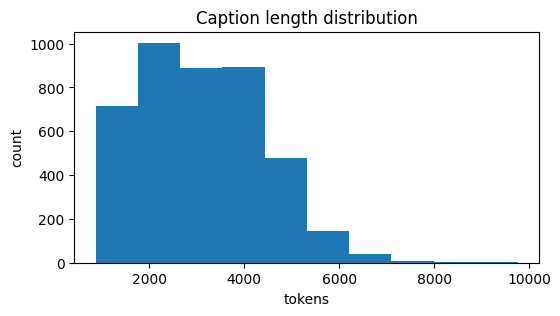

Showing first example frames:


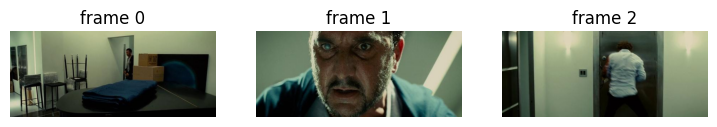

Caption token ids: [101, 1026, 1043, 4305, 3746, 2487, 1028, 1999, 1996, 25403, 4044, 1997, 1037, 20288, 2282, 3561, 2007, 1026, 1043, 3527, 27885, 3501, 2487, 1028, 19747, 8378, 1026, 1013, 1043, 3527, 1028, 1010, 1026, 1043, 3527, 27885, 3501, 2629, 1028, 1037, 2630, 8768, 1026, 1013, 1043, 3527, 1028, 1010, 1998, 1026, 1043, 3527, 1038, 2290, 23833, 1028, 1037, 2795, 1026, 1013, 1043, 3527, 1028, 1010, 1026, 1043, 3527, 25869, 2487, 1028, 2508, 1026, 1013, 1043, 3527, 1028, 1026, 1043, 2850, 25869, 2487, 1028, 8039, 1026, 1013, 1043, 2850, 1028, 2007, 1037, 8699, 2298, 1012, 2010, 2227, 11138, 1996, 5475, 2077, 1996, 4040, 1012, 1026, 1043, 3527, 25869, 2487, 1028, 2508, 1026, 1013, 1043, 3527, 1028, 1026, 1043, 2850, 25869, 2487, 1028, 8039, 1026, 1013, 1043, 2850, 1028, 2019, 4064, 2282, 2008, 4324, 1996, 11270, 1997, 2054, 3504, 2066, 1037, 15789, 4704, 2436, 1012, 1996, 2282, 1005, 1055, 1026, 1043, 19422, 1038, 2290, 2487, 1028, 8699, 7497, 1026, 1013, 1043, 19422, 1028, 1998, 

In [8]:
# Cell 3: EDA - show some images and caption length distribution
from collections import Counter
import matplotlib.pyplot as plt

# caption lengths
cap_lens = [len(ex['caption_tokens']) for ex in examples]
print("Caption lengths: min, mean, max:", min(cap_lens), np.mean(cap_lens), max(cap_lens))

plt.figure(figsize=(6,3))
plt.hist(cap_lens, bins=10)
plt.title("Caption length distribution")
plt.xlabel("tokens"); plt.ylabel("count")
plt.show()

# show first example frames
def show_sequence_frames(example, cols=3, figsize=(9,3)):
    seq = example['images']
    n = len(seq)
    plt.figure(figsize=figsize)
    for i, im in enumerate(seq[:cols]):
        plt.subplot(1, cols, i+1)
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"frame {i}")
    plt.show()

print("Showing first example frames:")
show_sequence_frames(examples[0], cols=config['dataset']['seq_len'])
print("Caption token ids:", examples[0]['caption_tokens'])


In [9]:
# Cell 4: Build tf.data train/val datasets (80/20 split)
train_ds, val_ds, (n_train, n_val) = build_tf_datasets_from_examples(examples, config, val_ratio=0.2, seed=42)
print("Train examples:", n_train, "Val examples:", n_val)

# show shapes of a single batch
for batch in train_ds.take(1):
    inputs, targets = batch
    print("images batch shape:", inputs['images_seq'].shape)
    print("caption batch shape:", inputs['caption_tokens'].shape)
    break


Train examples: 3343 Val examples: 835
images batch shape: (16, 3, 128, 128, 3)
caption batch shape: (16, 32)


In [10]:
# Cell 5: Build model and run one forward pass to ensure shapes are okay
model = build_model(config)  # builds & runs a dummy pass internally
print("Model built. Summary (call model to see weights):")
# We won't call model.summary() because it's a subclassed model; but building above ensures weights exist.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


c:\Users\rahul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'story_reasoning_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model built. Summary (call model to see weights):


In [11]:
# Cell 5.5: Ensure lr is native Python float and reload train module
import importlib
# Coerce config LR to a native Python float to avoid numpy scalar issues in TF optimizers
config['training']['lr'] = float(config['training']['lr'])
import src.train as train_mod
importlib.reload(train_mod)
train_loop = train_mod.train_loop
print('coerced config[training][lr] type ->', type(config['training']['lr']))

coerced config[training][lr] type -> <class 'float'>


Reloaded src.train from c:\Users\rahul\Desktop\35041968\src\train.py
Epoch 1/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 2152s 10s/step - loss: 5.3818 - val_loss: 4.1200
Epoch 2/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1184s 6s/step - loss: 3.9688 - val_loss: 3.8832
Epoch 3/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1111s 5s/step - loss: 3.4741 - val_loss: 3.1092
Epoch 4/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1110s 5s/step - loss: 2.6266 - val_loss: 2.3173
Epoch 5/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1236s 6s/step - loss: 2.0152 - val_loss: 1.8794


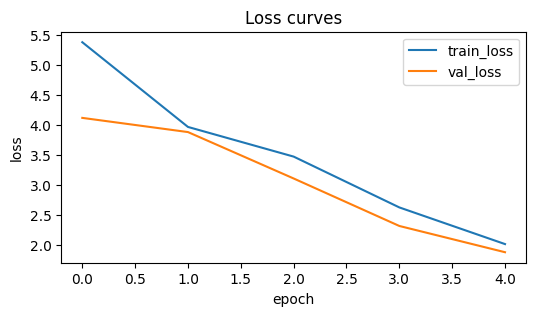

In [12]:
# Cell 6: TRAINING
# This calls the train_loop(config, examples) defined in train.py.
# It will use the same examples variable (the 80/20 split is inside train_loop).
# Warning: training can take time depending on dataset size and GPU availability.

# Ensure the module is reloaded and lr is a native float (safe guard)
import importlib
config['training']['lr'] = float(config['training']['lr'])
importlib.reload(train_mod)
print('Reloaded src.train from', train_mod.__file__)
model, history = train_mod.train_loop(config, examples, resume_ckpt=None)

# Plot training & validation loss if available in history
if hasattr(history, 'history'):
    h = history.history
    plt.figure(figsize=(6,3))
    plt.plot(h.get('loss', []), label='train_loss')
    plt.plot(h.get('val_loss', []), label='val_loss')
    plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Loss curves')
    plt.show()
else:
    print("No history returned (train_loop may have used a non-Keras fit path).")


In [13]:
# Cell 7: Load best checkpoint if it exists and run evaluation (token-level accuracy)
save_dir = config['training'].get('save_dir', 'results/checkpoints')
best_ckpt = os.path.join(save_dir, 'best.weights.h5')
if os.path.exists(best_ckpt):
    print("Loading best weights from:", best_ckpt)
    model.load_weights(best_ckpt)
else:
    print("No best checkpoint found at", best_ckpt, "- using current model weights.")

# Greedy predictions on test set
# We'll collect predicted token ids and true token ids across val_ds
all_pred_tokens = []
all_true_tokens = []

for batch in val_ds:
    inputs, targets = batch
    imgs = inputs['images_seq']
    # model returns greedy token ids when no caption_tokens passed
    preds = model({'images_seq': imgs}, training=False)  # shape (B, max_reason_len) of ints
    if isinstance(preds, tf.Tensor):
        preds = preds.numpy()
    all_pred_tokens.append(preds)
    all_true_tokens.append(targets.numpy())

all_pred_tokens = np.concatenate(all_pred_tokens, axis=0)
all_true_tokens = np.concatenate(all_true_tokens, axis=0)
print("Pred shape:", all_pred_tokens.shape, "True shape:", all_true_tokens.shape)

# Compute simple token-level accuracy ignoring pad token
pad_id = config['model']['pad_token_id']
mask = (all_true_tokens != pad_id)
correct = (all_pred_tokens == all_true_tokens) & mask
tok_acc = correct.sum() / mask.sum()
print(f"Token-level accuracy (ignoring pad): {tok_acc:.4f}")


Loading best weights from: results/checkpoints\best.weights.h5
Pred shape: (835, 32) True shape: (835, 32)
Token-level accuracy (ignoring pad): 0.0312


Example #0
True: 101 1026 1043 4305 3746 2487 1028 1999 1996 1026 1043 19422 1038 2290 2487 1028 2436 6797 1026 1013 1043 19422 1028 1997 1037 1026 1043 19422 1038 2290 2475 1028
Pred: 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101 101
Showing first few batches from val_ds (frames):


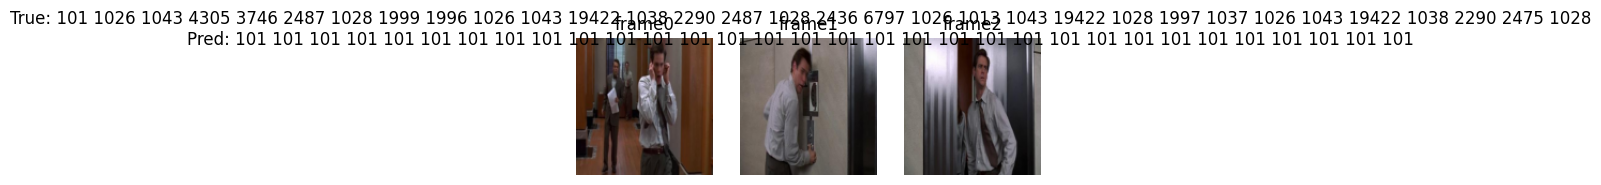

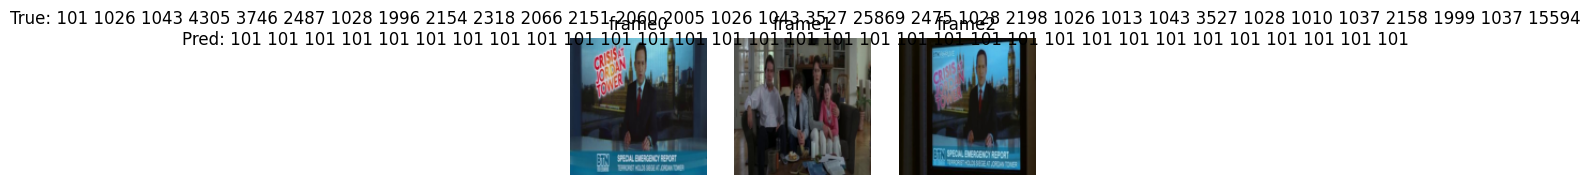

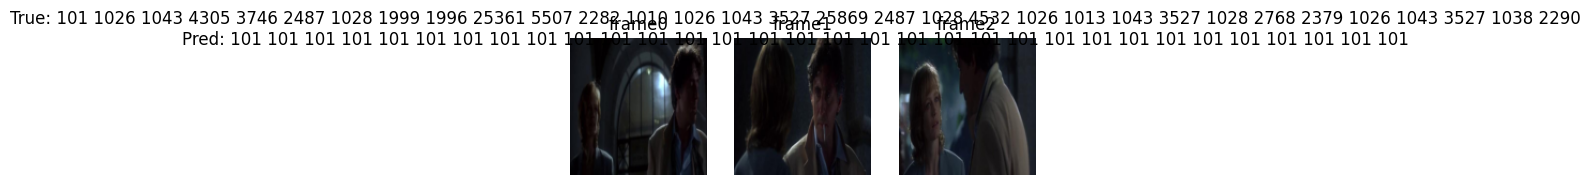

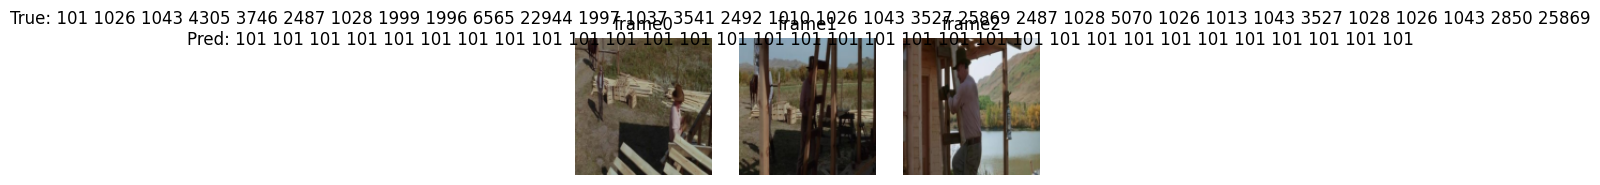

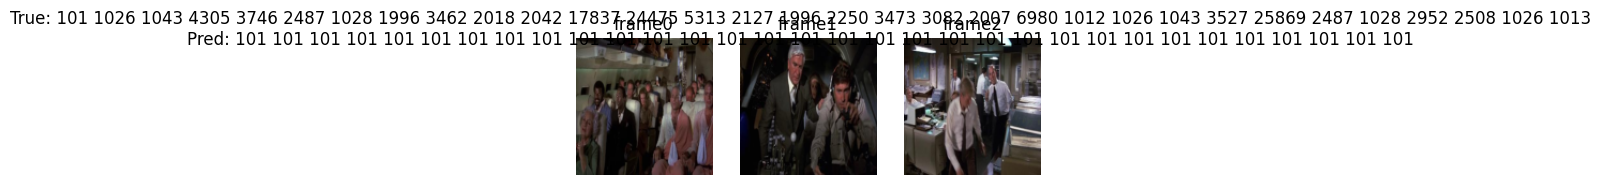

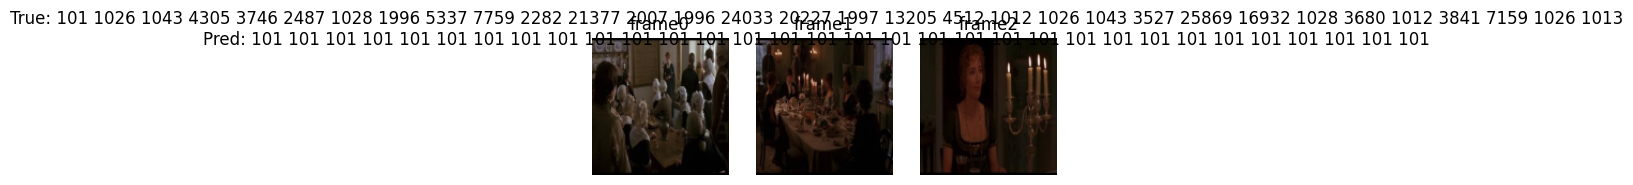

In [14]:
# Cell 8: Visualize predictions for a handful of validation examples
def detokenize(token_seq):
    # Simple detokenizer: join token ids into a string (replace with real tokenizer's decode)
    return ' '.join(str(int(x)) for x in token_seq if x != pad_id)

num_show = 6
for i in range(num_show):
    # pick i-th validation example (from concatenated arrays)
    true_tok = all_true_tokens[i]
    pred_tok = all_pred_tokens[i]
    print(f"Example #{i}")
    print("True:", detokenize(true_tok))
    print("Pred:", detokenize(pred_tok))
    # show frames: we need original PIL frames from examples' val split — reconstruct index
    # We used a shuffled split inside train_loop; easiest is to take from our earlier split in build_tf_datasets_from_examples
    # We'll show images by extracting from val_ds
    # Take the i-th batch element from val_ds generator (inefficient but fine for a few examples)
    break  # we'll show images below separately

# Show actual frames from a few samples in val_ds
print("Showing first few batches from val_ds (frames):")
count = 0
for inputs, targets in val_ds.take(3):
    imgs = inputs['images_seq'].numpy()  # (B, S, H, W, C)
    bs = imgs.shape[0]
    for b in range(bs):
        if count >= num_show: break
        fig, axs = plt.subplots(1, imgs.shape[1], figsize=(imgs.shape[1]*2,2))
        for s in range(imgs.shape[1]):
            axs[s].imshow(imgs[b,s].astype('uint8'))
            axs[s].axis('off')
            axs[s].set_title(f"frame{s}")
        plt.suptitle(f"True: {detokenize(targets.numpy()[b])}\nPred: {detokenize(all_pred_tokens[count])}")
        plt.show()
        count += 1
    if count >= num_show: break


In [15]:
# Cell 9: save predictions and truth to a CSV for further analysis
import csv
out_csv = os.path.join(save_dir, 'val_predictions.csv')
with open(out_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['index', 'true_tokens', 'pred_tokens'])
    for i in range(all_true_tokens.shape[0]):
        writer.writerow([i, ' '.join(map(str, all_true_tokens[i])), ' '.join(map(str, all_pred_tokens[i]))])
print("Saved predictions to:", out_csv)


Saved predictions to: results/checkpoints\val_predictions.csv


In [16]:
# Cell 10: Optional BLEU (token-level). Install NLTK if you want real BLEU.
# We'll compute a simple unigram BLEU-like precision as an example (not true BLEU).
def unigram_precision(pred_seq, true_seq):
    # ignore pads
    pred = [p for p in pred_seq if p != pad_id]
    true = [t for t in true_seq if t != pad_id]
    if len(pred) == 0:
        return 0.0
    tp = sum(1 for p in pred if p in true)
    return tp / len(pred)

precisions = [unigram_precision(all_pred_tokens[i], all_true_tokens[i]) for i in range(all_true_tokens.shape[0])]
print("Mean unigram precision:", np.mean(precisions))


Mean unigram precision: 1.0
